In [1]:
%env CUDA_VISIBLE_DEVICES=

env: CUDA_VISIBLE_DEVICES=


In [2]:
%matplotlib inline

In [3]:
import jax.numpy as np
import jax.scipy.stats.norm
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt
from simulation import E_0, eV

In [4]:
# TODO(kazeevn) save in experimets files
T_RANGE = np.linspace(1, 1800, num=5000, dtype=np.float32)
lattice_parameters = np.array([np.pi/2, np.pi/3], dtype=np.float32)

In [10]:
results = []
energy_deltas_ev = (0.,0.25,0.5,1.,1.5,2.)
for energy_delta_ev in energy_deltas_ev:
    results.append(list(np.load(f"data/results_{energy_delta_ev}_eV.npz").values())[0])

In [11]:
def window_average(array, N):
    cumsum = np.cumsum(array)
    return (cumsum[N:]-cumsum[:-N])/N

In [12]:
def window_mean_std(array, N):
    mean = window_average(array, N)
    delta_2 = window_average(array**2, N) - mean**2
    std = np.sqrt(delta_2*N/(N-1))
    return mean, std

In [13]:
def cut_head_tail(array, N):
    return array[N//2:-(N//2 + (N%2))]

In [14]:
def smooth_phase(phases, phases_std, smooth_N):
    phase_probas = jax.scipy.stats.norm.pdf(
        phases,
        loc=0,
        scale=np.expand_dims(phases_std.mean(axis=1), 1))
    normed_probas = phase_probas/np.expand_dims(phase_probas.sum(axis=1), 1)
    observed_phase = (lattice_parameters*normed_probas).sum(axis=1)
    
    smooth_phase_angle, smooth_phase_discrepancy = window_mean_std(observed_phase, smooth_N)
    
    inner_discrepancy = window_average((phases*normed_probas).sum(axis=1), smooth_N)
    smooth_phase_discrepancy = np.sqrt(smooth_phase_discrepancy**2 + inner_discrepancy**2)
    return smooth_phase_angle, smooth_phase_discrepancy

In [15]:
from simulation import tau_0
# Simulation time in picoseconds
20000*tau_0/1e-12

800.0

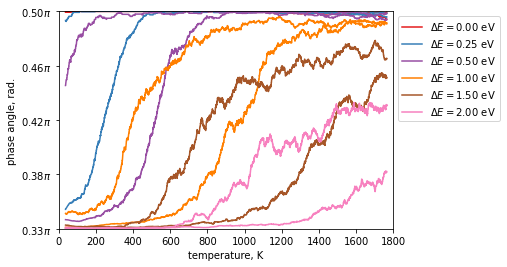

In [21]:
smooth_N = 200
smooth_temperature = window_average(T_RANGE, smooth_N)
fig, ax = plt.subplots()
cm = plt.get_cmap('Set1')
for index, (energy, all_phases) in enumerate(zip(energy_deltas_ev, results)):
    for lattice_index, (phases, phases_std) in enumerate(all_phases):
        smooth_phase_angle, smooth_phase_discrepancy = smooth_phase(phases, phases_std, smooth_N)    
        ax.plot(smooth_temperature,
                smooth_phase_angle,
                label=f"$\Delta E={energy:.2f}$ eV" if lattice_index==0 else None,
                c=cm(index/len(results)))

ax.set_xlabel("temperature, K")
ax.set_ylabel("phase angle, rad.")
ax.set_xlim(np.nanmin(smooth_temperature), np.nanmax(smooth_temperature))
ax.set_ylim(np.nanmin(smooth_phase_angle), np.nanmax(smooth_phase_angle));
ticks_in_pi = np.linspace(1/3, 1/2, num=5)
ax.yaxis.set_ticks(np.pi*ticks_in_pi)
ax.yaxis.set_ticklabels([f"${i:.2f}\pi$" for i in ticks_in_pi])
ax.set_xlim((0, np.max(T_RANGE)));
#ax.set_ylim(np.pi/3-0.15, np.pi/2+0.15);
ax.legend(bbox_to_anchor=(1, 1), loc=2);
fig.savefig("plots/all_trajectories.pdf", bbox_inches="tight")
fig.savefig("plots/all_trajectories.jpg", bbox_inches="tight", dpi=300)

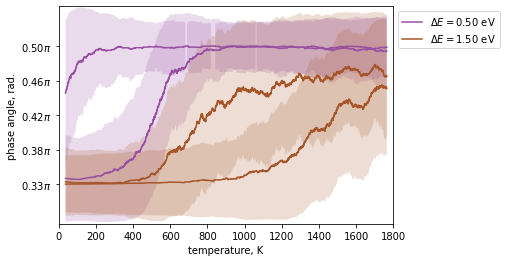

In [23]:
indices = (2, 4)
fig, ax = plt.subplots()
for index in indices:
    energy = energy_deltas_ev[index]
    all_phases = results[index]
    for lattice_index, (phases, phases_std) in enumerate(all_phases):
        smooth_phase_angle, smooth_phase_discrepancy = smooth_phase(phases, phases_std, smooth_N)
        color = cm(index/len(results))
        ax.plot(smooth_temperature,
                smooth_phase_angle,
                label=f"$\Delta E={energy:.2f}$ eV" if lattice_index==0 else None,
                c=color)
        ax.fill_between(smooth_temperature,
                                smooth_phase_angle - smooth_phase_discrepancy,
                                smooth_phase_angle + smooth_phase_discrepancy,
                                alpha=0.2, facecolor=color)

ax.set_xlabel("temperature, K")
ax.set_ylabel("phase angle, rad.")
ax.set_xlim(np.nanmin(smooth_temperature), np.nanmax(smooth_temperature))
ax.set_ylim(np.nanmin(smooth_phase_angle), np.nanmax(smooth_phase_angle));
ticks_in_pi = np.linspace(1/3, 1/2, num=5)
ax.yaxis.set_ticks(np.pi*ticks_in_pi)
ax.yaxis.set_ticklabels([f"${i:.2f}\pi$" for i in ticks_in_pi])
ax.set_xlim((0, np.max(T_RANGE)));
ax.set_ylim(np.pi/3-0.15, np.pi/2+0.15);
ax.legend(bbox_to_anchor=(1, 1), loc=2);
fig.savefig("plots/selected_trajectories.pdf", bbox_inches="tight")
fig.savefig("plots/selected_trajectories.jpg", bbox_inches="tight", dpi=300)

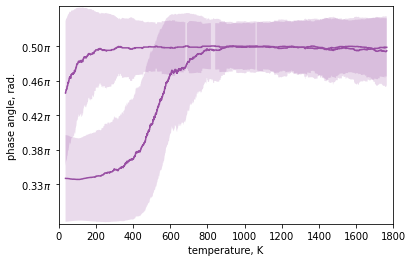

In [25]:
indices = (2,)
fig, ax = plt.subplots()
for index in indices:
    energy = energy_deltas_ev[index]
    all_phases = results[index]
    for lattice_index, (phases, phases_std) in enumerate(all_phases):
        smooth_phase_angle, smooth_phase_discrepancy = smooth_phase(phases, phases_std, smooth_N)
        color = cm(index/len(results))
        ax.plot(smooth_temperature,
                smooth_phase_angle,
                c=color)
        ax.fill_between(smooth_temperature,
                                smooth_phase_angle - smooth_phase_discrepancy,
                                smooth_phase_angle + smooth_phase_discrepancy,
                                alpha=0.2, facecolor=color)

ax.set_xlabel("temperature, K")
ax.set_ylabel("phase angle, rad.")
ax.set_xlim(np.nanmin(smooth_temperature), np.nanmax(smooth_temperature))
ax.set_ylim(np.nanmin(smooth_phase_angle), np.nanmax(smooth_phase_angle));
ticks_in_pi = np.linspace(1/3, 1/2, num=5)
ax.yaxis.set_ticks(np.pi*ticks_in_pi)
ax.yaxis.set_ticklabels([f"${i:.2f}\pi$" for i in ticks_in_pi])
ax.set_xlim((0, np.max(T_RANGE)));
ax.set_ylim(np.pi/3-0.15, np.pi/2+0.15);
fig.savefig("plots/single_trajectory.pdf", bbox_inches="tight")
fig.savefig("plots/single_trajectory.jpg", bbox_inches="tight", dpi=300)